In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from model import get_model
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import f1_score, accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
data = pd.read_csv("data/mitbih_train.csv", header = None)
train = data.sample(frac = 1, random_state = 42)
test = pd.read_csv("data/mitbih_test.csv", header = None)

In [4]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890360,0.758160,0.423972,0.219104,0.201127,0.210399,0.205808,0.201773,0.198691,0.196757,...,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807,0.473376
std,0.240909,0.221813,0.227305,0.206878,0.177058,0.171909,0.178481,0.177240,0.171778,0.168357,...,0.044154,0.042089,0.040525,0.038651,0.037193,0.036255,0.034789,0.032865,0.031924,1.143184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.991342,0.826013,0.429472,0.166000,0.147878,0.158798,0.145324,0.144424,0.150000,0.148734,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.910506,0.578767,0.341727,0.258993,0.287628,0.298237,0.295391,0.290832,0.283636,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


In [6]:
len(train.columns), len(train)

(188, 87554)

In [7]:
data[len(train.columns)-1].value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

In [8]:
Y = np.array(train[len(train.columns)-1].values)
X = np.array(train[list(range(len(train.columns)-1))])[..., np.newaxis]

Y_test = np.array(test[len(train.columns)-1].values)
X_test = np.array(test[list(range(len(test.columns)-1))].values)[..., np.newaxis]

In [9]:
chkpt = ModelCheckpoint(filepath = "model_initial.h5", monitor = "val_acc", mode = 'max', save_best_only = True, verbose = 1)
early = EarlyStopping(monitor = "val_acc", mode = "max", patience = 5, verbose = 1)
redonplat = ReduceLROnPlateau(monitor = "val_acc", mode = "max", patience = 3, verbose = 2)

callbacks_list = [chkpt, early, redonplat]

In [10]:
strategy = tf.distribute.experimental.CentralStorageStrategy()

print(f'Number of devices: {strategy.num_replicas_in_sync}')

INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ('/device:GPU:0',), variable_device = '/device:GPU:0'
Number of devices: 1


In [11]:
with strategy.scope():
    model = get_model(X.shape[1], X.shape[2], data[len(train.columns)-1].nunique())
    
    opt = tf.keras.optimizers.Adam(0.001)

    model.compile(optimizer = opt, loss = tf.keras.losses.sparse_categorical_crossentropy, metrics = ['acc'])

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 183, 16)           96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 179, 16)           1296      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 89, 16)            0         
_________________________________________________________________
dropout (Dropout)            (None, 89, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 87, 32)            1568      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 85, 32)            3104  

In [13]:
model.fit(X, Y, batch_size = 128, epochs = 10, verbose = 1, callbacks = callbacks_list, validation_split = 0.1)

INFO:tensorflow:Running local Distribute Coordinator.
Train on 78798 samples, validate on 8756 samples
Epoch 1/10
78592/78798 [============================>.] - ETA: 0s - loss: 0.4520 - acc: 0.8562
Epoch 00001: val_acc improved from -inf to 0.91583, saving model to model_initial.h5
78798/78798 [==============================] - 13s 159us/sample - loss: 0.4516 - acc: 0.8563 - val_loss: 0.2857 - val_acc: 0.9158
Epoch 2/10
78336/78798 [============================>.] - ETA: 0s - loss: 0.2918 - acc: 0.9137
Epoch 00002: val_acc improved from 0.91583 to 0.93433, saving model to model_initial.h5
78798/78798 [==============================] - 6s 75us/sample - loss: 0.2913 - acc: 0.9139 - val_loss: 0.2319 - val_acc: 0.9343
Epoch 3/10
78336/78798 [============================>.] - ETA: 0s - loss: 0.2438 - acc: 0.9300
Epoch 00003: val_acc improved from 0.93433 to 0.94724, saving model to model_initial.h5
78798/78798 [==============================] - 6s 81us/sample - loss: 0.2439 - acc: 0.9299 - 

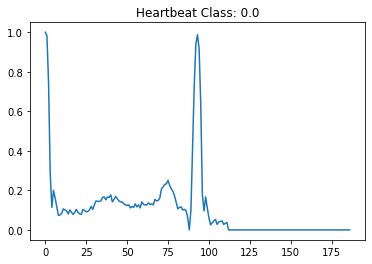

In [14]:
i = np.random.choice(X.shape[0])
plt.plot(X[i].flatten())
plt.title("Heartbeat Class: " + str(Y[i]))
plt.show()

In [15]:
pred_test = np.argmax(model.predict(X_test), axis = -1)

In [16]:
f1 = f1_score(Y_test, pred_test, average="macro")

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test f1 score : 0.8169160577564447 
Test accuracy score : 0.9642791887447469 


In [17]:
model.save("MIT-BH.h5")